# Prerequisites

Please upload the following files to this notebook:

- *train.tsv*
- *test.tsv*

# Data Analysis & Preprocessing

Firstly, let's take a look at the data.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import chardet

In [2]:
train_path = './train.tsv'
with open(train_path, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
train_encoding = result['encoding']
print('Encoding for ' + train_path + ': ' + train_encoding)

test_path = './test.tsv'
with open(test_path, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
test_encoding = result['encoding']
print('Encoding for ' + test_path + ': ' + test_encoding)

Encoding for ./train.tsv: utf-8
Encoding for ./test.tsv: utf-8


### Opening *train.tsv* and *test.tsv*

In [3]:
train_df = pd.read_csv(train_path, encoding=train_encoding, sep='\t')
print(f"There are {len(train_df)} examples in train.tsv\n")

print("Data types:")
print(train_df.dtypes)

train_df.head()

There are 5758 examples in train.tsv

Data types:
title      object
is_fake     int64
dtype: object


,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [4]:
test_df = pd.read_csv(test_path, encoding=test_encoding, sep='\t')
print(f"There are {len(test_df)} examples in test.tsv\n")

print("Data types:")
print(test_df.dtypes)

test_df.head()

There are 1000 examples in test.tsv

Data types:
title      object
is_fake     int64
dtype: object


,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0


Check the files for duplicates:

In [5]:
train_df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
5753    False
5754    False
5755    False
5756    False
5757    False
Length: 5758, dtype: bool

In [6]:
test_df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool

Check the files for missing values:

In [7]:
train_df.isna().mean()

title      0.0
is_fake    0.0
dtype: float64

In [8]:
test_df.isna().mean()

title      0.0
is_fake    0.0
dtype: float64

## Language Processing Pipeline

Save the initial string to compare it with result later:

In [9]:
initial_line = test_df['title'].loc[0]
initial_line

'Роскомнадзор представил реестр сочетаний цветов, нежелательных в России'

### Converting text to lowercase

In [10]:
train_df['title'] = train_df['title'].apply(lambda x: x.lower())
test_df['title'] = test_df['title'].apply(lambda x: x.lower())
test_df['title'].loc[0]

'роскомнадзор представил реестр сочетаний цветов, нежелательных в россии'

### Removing punciation

In [11]:
import string

def remove_punctuation(text):
    # there are tricky quote characters aren't present in string.punctuation, so concat them with string.punctuation
    chars_no_punctuation = [char for char in text if char not in string.punctuation + '«»']
    text_no_punctuation = ''.join(chars_no_punctuation)
    return text_no_punctuation

train_df['title'] = train_df['title'].apply(remove_punctuation)
test_df['title'] = test_df['title'].apply(remove_punctuation)
test_df['title'].loc[0]

'роскомнадзор представил реестр сочетаний цветов нежелательных в россии'

### Removing stopwords

In [12]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('russian')) 

train_df['title'] = train_df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
test_df['title'] = test_df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
test_df['title'].loc[0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'роскомнадзор представил реестр сочетаний цветов нежелательных россии'

### Text lemmatization

In [13]:
!pip install stanza
!pip install pymorphy2==0.8

     |████████████████████████████████| 574 kB 12.4 MB/s 
     |████████████████████████████████| 4.0 MB 44.4 MB/s 
     |████████████████████████████████| 175 kB 45.0 MB/s 
     |████████████████████████████████| 596 kB 37.1 MB/s 
     |████████████████████████████████| 895 kB 46.0 MB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
     |████████████████████████████████| 6.6 MB 43.4 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=98ef0fbd151e0b15e944994c6f194c4c22b5cfc6a5183da92a70a0682842c0d9
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 46 kB 2.7 MB/s 
     |████████████████████████████████| 7.1 MB 22.0 MB/s 


In [14]:
import stanza

stanza.download('ru')   # download Russian lemmatization model, takes time

nlp = stanza.Pipeline("ru") # initialize Russian neural pipeline

2022-04-24 19:32:45 INFO: Downloading default packages for language: ru (Russian)...


2022-04-24 19:33:08 INFO: Finished downloading models and saved to /root/stanza_resources.


2022-04-24 19:33:12 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |
| depparse  | syntagrus |
| ner       | wikiner   |

2022-04-24 19:33:12 INFO: Use device: gpu
2022-04-24 19:33:12 INFO: Loading: tokenize
2022-04-24 19:33:28 INFO: Loading: pos
2022-04-24 19:33:28 INFO: Loading: lemma
2022-04-24 19:33:29 INFO: Loading: depparse
2022-04-24 19:33:29 INFO: Loading: ner
2022-04-24 19:33:31 INFO: Done loading processors!


In [15]:
def lemmatize(text):
    doc = nlp(text)
    lemmatized_words = [word.lemma for sent in doc.sentences for word in sent.words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

train_df['title'] = train_df['title'].apply(lemmatize)
test_df['title'] = test_df['title'].apply(lemmatize)

'роскомнадзор представить реестр сочетание цветы нежелательный россия'

Take a look at the results of preprocessing:

In [16]:
print(initial_line)
print(test_df['title'].loc[0])

Роскомнадзор представил реестр сочетаний цветов, нежелательных в России
роскомнадзор представить реестр сочетание цветы нежелательный россия


## Analysis

### Real-to-Fake ratio

Let us check the ratio of real to fake news:

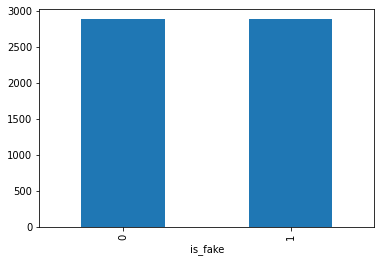

In [17]:
train_df.groupby(['is_fake'])['title'].count().plot(kind='bar')
plt.show()

### Most frequent words

Most frequent words for real and fake news:

In [18]:
test_df

,title,is_fake
0,роскомнадзор представить реестр сочетание цвет...,0
1,ночь минский президентский горе беларашмор пик...,0
2,бывший спичрайтер юрий лоза рассказать труднос...,0
3,сельский церковь собрать рекордно низкий колич...,0
4,акция Хиплос рухнуть объявление перезапуска ru...,0
...,...,...
995,прокуратура заподозрить явлинский авторитарный...,0
996,день победа стратегический ракетоносец ту160 д...,0
997,ск возбудить дело против авиакомпания победа ф...,0
998,криптомонетный двор туркменистан выпустить юби...,0


In [19]:
import seaborn as sns
import nltk
from nltk import tokenize

def words_freq_plotter(df, col_name, num_of_bars):
    all_words = ' '.join([text for text in df[col_name]])
    token_space = tokenize.WhitespaceTokenizer()
    token_phrase = token_space.tokenize(all_words)
    frequency_dict = nltk.FreqDist(token_phrase)

    frequency_df = pd.DataFrame({"Word": list(frequency_dict.keys()),
                                   "Frequency": list(frequency_dict.values())})
    frequency_df = frequency_df.nlargest(columns = "Frequency", n = num_of_bars)

    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = frequency_df, x = "Word", y = "Frequency", color='blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

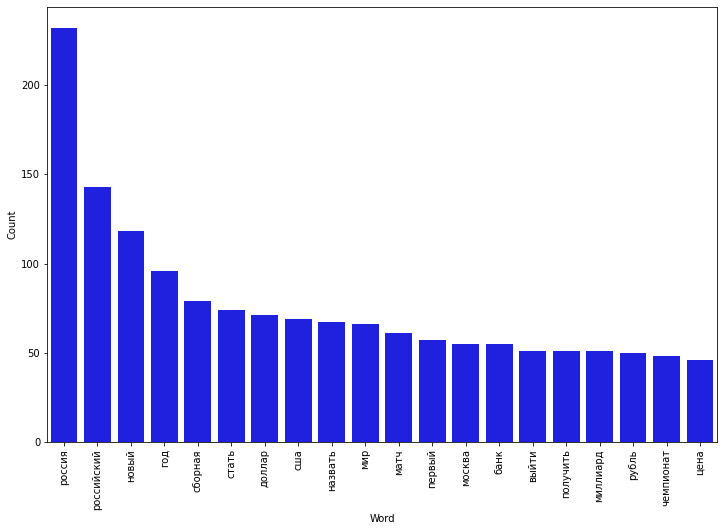

In [20]:
words_freq_plotter(train_df[train_df['is_fake'] == False], 'title', 20)

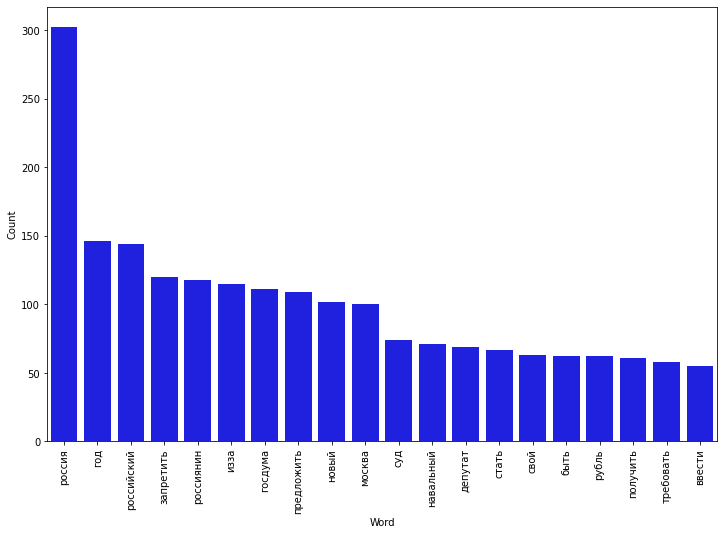

In [21]:
words_freq_plotter(train_df[train_df['is_fake'] == True], 'title', 20)

# Building a Model

Split the dataset into train and test sets:

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['title'], train_df['is_fake'],
                                                    test_size=0.2, random_state=42)

## Logistic Regression

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# set up a model pipeline
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression(C=2.0, dual=True, solver='liblinear'))])

# apply cross-validation to estimate the performance
cv_f1_score = cross_val_score(pipe, train_df['title'], train_df['is_fake'], cv=6, scoring='f1')
f1_score_val_cv_mean = cv_f1_score.mean()

# Fitting the model
model = pipe.fit(X_train, y_train)

# f1 score metrics
predictions = model.predict(X_test)
f1_score_val = f1_score(y_test, predictions)
print(f"F1 score of the model: {f1_score_val}")
print(f"F1 score of the model (cross-validated): {f1_score_val_cv_mean}")

F1 score of the model: 0.8363324764353042
F1 score of the model (cross-validated): 0.8427677473822346


# Saving Predictions to *test.tsv*

In [24]:
test_pred_df = pd.read_csv('test.tsv', encoding=test_encoding, sep='\t')
test_pred_df.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0


In [25]:
predictions = model.predict(test_df['title'])
test_pred_df['is_fake'] = predictions
test_pred_df.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",1
4,Акции Google рухнули после объявления о переза...,0


In [26]:
test_pred_df.to_csv('predictions.tsv', sep="\t", columns=['title', 'is_fake'])

# Results

#### Performance

F1 score obtained with Logistic Regression:

In [27]:
print("F1 score = %0.5f" % f1_score_val)

F1 score = 0.83633


The model has been fitted using GridSearchCV, and the best parameters obtained were used in the model.

#### What's further?

- I would like to improve the solution and obtain **0.9 f1-score** with this task. I'm pretty sure I'm gonna change the model to achieve this. I want to learn about LSTMs, embeddings,  transformers, and the way they can be applied to solve this task.

- Overall, I enjoyed working on the problem. It was my first experience with NLP, and I definitely want to practice more in this branch.